In [121]:
import pandas, numpy
import matplotlib.pyplot as plt 
import seaborn as sns

In [122]:
applications = pandas.read_csv("./application_record.csv")
credit_records = pandas.read_csv("./credit_record.csv")

In [123]:
# Let's take a look at each dataset individually 
applications.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [124]:
# Lets' see how the credit record looks like 
# 1 - due less 30 days
# 2 - due 30 - 60 days 
# 3 - due 60 - 90 days
# 4 - due 90 - 150 days 
# 5 - due over 150 days 

credit_records.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [125]:
# Relabling Credit Records Dataset

CREDIT_MAPPING = {
    "ID": "client_id",
    "STATUS": "due_status",
    "MONTHS_BALANCE": "balance_month"
}
credit_records.rename(columns=CREDIT_MAPPING, inplace=True)

print(credit_records)

# Relabling Applications Records Dataset
APPLICATION_MAPPING = {
    "ID": "client_id",
    "CODE_GENDER": "gender",
    "FLAG_OWN_CAR": "has_car",
    "FLAG_OWN_REALTY": "has_realty",
    "CNT_CHILDREN": "total_children",
    "AMT_INCOME_TOTAL": "annual_income",
    "NAME_INCOME_TYPE": "income_category",
    "NAME_EDUCATION_TYPE": "education_category",
    "NAME_FAMILY_STATUS": "family_status",
    "NAME_HOUSING_TYPE": "living_place",
    "DAYS_BIRTH": "birthday",
    "FLAG_MOBIL": "has_mobile_phone",
    "FLAG_PHONE": "has_phone",
    "FLAG_WORK_PHONE": "has_work_phone",
    "FLAG_EMAIL": "has_email",
    "CNT_FAM_MEMBERS": "family_size",
    "OCCUPATION_TYPE": "job",
    'DAYS_EMPLOYED': 'days_employed',
}

applications.rename(columns=APPLICATION_MAPPING, inplace=True)

print(applications)

         client_id  balance_month due_status
0          5001711              0          X
1          5001711             -1          0
2          5001711             -2          0
3          5001711             -3          0
4          5001712              0          C
...            ...            ...        ...
1048570    5150487            -25          C
1048571    5150487            -26          C
1048572    5150487            -27          C
1048573    5150487            -28          C
1048574    5150487            -29          C

[1048575 rows x 3 columns]
        client_id gender has_car has_realty  total_children  annual_income  \
0         5008804      M       Y          Y               0       427500.0   
1         5008805      M       Y          Y               0       427500.0   
2         5008806      M       Y          Y               0       112500.0   
3         5008808      F       N          Y               0       270000.0   
4         5008809      F       N          

In [126]:
# Editing Dataset Labels for better understanding and easier usage 
applications.info()
applications.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           438557 non-null  int64  
 1   gender              438557 non-null  object 
 2   has_car             438557 non-null  object 
 3   has_realty          438557 non-null  object 
 4   total_children      438557 non-null  int64  
 5   annual_income       438557 non-null  float64
 6   income_category     438557 non-null  object 
 7   education_category  438557 non-null  object 
 8   family_status       438557 non-null  object 
 9   living_place        438557 non-null  object 
 10  birthday            438557 non-null  int64  
 11  days_employed       438557 non-null  int64  
 12  has_mobile_phone    438557 non-null  int64  
 13  has_work_phone      438557 non-null  int64  
 14  has_phone           438557 non-null  int64  
 15  has_email           438557 non-nul

client_id                  0
gender                     0
has_car                    0
has_realty                 0
total_children             0
annual_income              0
income_category            0
education_category         0
family_status              0
living_place               0
birthday                   0
days_employed              0
has_mobile_phone           0
has_work_phone             0
has_phone                  0
has_email                  0
job                   134203
family_size                0
dtype: int64

In [127]:
# Let's see how many nan values we have in credit records dataset
credit_records.info() 
credit_records.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   client_id      1048575 non-null  int64 
 1   balance_month  1048575 non-null  int64 
 2   due_status     1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


client_id        0
balance_month    0
due_status       0
dtype: int64

In [128]:
# Let's see how many unique application records we have
applications['client_id'].nunique()

438510

In [129]:
# Let's see how many unique credit record we have
credit_records["client_id"].nunique()

45985

In [130]:
# let's see how many intersections to we have 
applications.merge(credit_records, on="client_id")["client_id"].nunique()

36457

In [131]:
# Calculating credit window for each individual customer 

grouped = credit_records.groupby('client_id')
customer_credit = pandas.DataFrame()

customer_credit['open_month'] = grouped['balance_month'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
customer_credit['end_month'] = grouped['balance_month'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account

customer_credit["credit_window"] = customer_credit["end_month"] - customer_credit["open_month"] + 1
customer_credit.reset_index(inplace=True)

customer_credit = customer_credit[['client_id', 'credit_window']]
customer_credit

,client_id,credit_window
0,5001711,4
1,5001712,19
2,5001713,22
3,5001714,15
4,5001715,60
...,...,...
45980,5150482,18
45981,5150483,18
45982,5150484,13
45983,5150485,2


In [132]:
# Joining with main credit table and finding credit difference
DUE_DATATYPES = {
    "0": 0,
    "1": 0,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 1,
    "X": 0,
    "C": 0
}

def convert_due_status(status: str):
    """
    Transforms digit due statuses to meaningful names
    everything, that is higher than 1 marks as 'overdue', which indicates, 
    that client had a huge pay out delay and might be not reliable
    """
    if not isinstance(status, str): return 0

    if status.isdigit():
        if int(status) > 1: 
            return 1 
    return 0

# Mapping values according to specified standards

credit_records["due_status"] = credit_records['due_status'].map(lambda item: DUE_DATATYPES[str(item)])

# Overdue metrics per client

overdue_per_client = credit_records[["client_id", "due_status"]].groupby(
by=["client_id"])['due_status'].sum().to_frame('overdue_frequency').reset_index()


# Merging with clients
customer_credit = customer_credit.merge(overdue_per_client, on='client_id', how='inner')


# marking client as bed whether it has overdues or not 
customer_credit["bad_client"] = overdue_per_client["overdue_frequency"].apply(
func=lambda summary: True if summary > 0 else False)




customer_credit = customer_credit[["client_id", "credit_window", "bad_client"]]



def set_datatypes(dataset: pandas.DataFrame):
    """
    Optimizing datatypes for dataset compression
    """
    dataset["client_id"] = dataset["client_id"].astype(numpy.int64)
    dataset["credit_window"] = dataset["credit_window"].astype(numpy.int16)
    return dataset

completed_feature_dataset = set_datatypes(customer_credit)

# After Optimizing our dataset, let's check it's characteristics 

completed_feature_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   client_id      45985 non-null  int64
 1   credit_window  45985 non-null  int16
 2   bad_client     45985 non-null  bool 
dtypes: bool(1), int16(1), int64(1)
memory usage: 494.1 KB


In [133]:
# merging with main application records using left join (we want to keep customer's which does not have any )

Text(0.5, 0, 'Proportion of good and bad customers. Bad - 1; Good - 0')

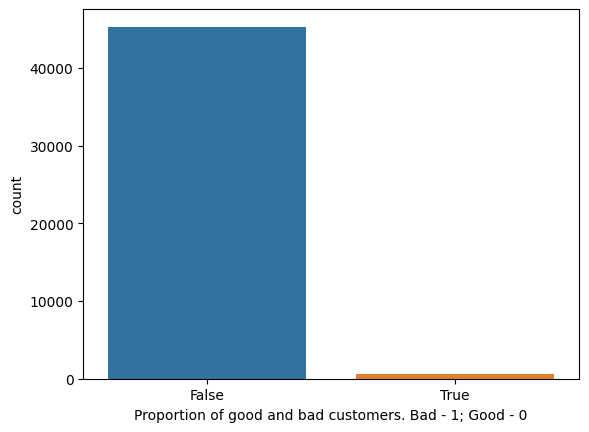

In [134]:
# Let's see how many clients are good (can be potentially considered by the banks) and bad clients

sns.countplot(data=completed_feature_dataset, x="bad_client")
plt.xlabel("Proportion of good and bad customers. Bad - 1; Good - 0")

In [135]:
# Let's investigate majority class to get more information about it 

origin_dataset = completed_feature_dataset.merge(applications, on='client_id')
origin_dataset.drop_duplicates(inplace=True)

In [136]:
feature_dataset = pandas.DataFrame() # main dataframe, containing all features

In [137]:
# Imputing missing values before encoding

origin_dataset.isna().sum()

client_id                 0
credit_window             0
bad_client                0
gender                    0
has_car                   0
has_realty                0
total_children            0
annual_income             0
income_category           0
education_category        0
family_status             0
living_place              0
birthday                  0
days_employed             0
has_mobile_phone          0
has_work_phone            0
has_phone                 0
has_email                 0
job                   11323
family_size               0
dtype: int64

In [138]:
# Using Mode Imputation for Nominal Categorical Feature 'Job'
print(origin_dataset['bad_client'].value_counts())
MISSING_JOB = "missing_job"
feature_dataset['job'] = origin_dataset['job'].fillna(MISSING_JOB)


bad_client
False    35841
True       616
Name: count, dtype: int64


In [139]:
# Using Imputation for Education and Family Status categories 

import math 

feature_dataset['client_id'] = origin_dataset['client_id']
feature_dataset['credit_window'] = origin_dataset['credit_window']

feature_dataset['bad_client'] = origin_dataset['bad_client']

feature_dataset['family_size'] = origin_dataset['family_size']
feature_dataset['total_children'] = origin_dataset['total_children']
feature_dataset['annual_income'] = origin_dataset['annual_income']

feature_dataset['living_place'] = origin_dataset['living_place'].apply(func=lambda item: item.lower())
feature_dataset['education_category'] = origin_dataset['education_category'].apply(func=lambda item: item.lower()) 
feature_dataset['family_status'] = origin_dataset['family_status'].apply(func=lambda item: item.lower())
feature_dataset['income_category'] = origin_dataset['income_category'].apply(func=lambda item: item.lower())

feature_dataset['employed']  = origin_dataset['days_employed'].apply(func=lambda day: False if day > 0 else True)
feature_dataset['age'] = origin_dataset['birthday'].apply(func=lambda day: math.floor(abs(day) / 365))


In [140]:
# Checking the imputation status 
feature_dataset.isna().sum()

job                   0
client_id             0
credit_window         0
bad_client            0
family_size           0
total_children        0
annual_income         0
living_place          0
education_category    0
family_status         0
income_category       0
employed              0
age                   0
dtype: int64

In [141]:
# Standardizing numeric data features 

from sklearn.preprocessing import StandardScaler
numeric_features = feature_dataset.select_dtypes(include='number').columns.tolist()

def scale_numeric_features(data: pandas.DataFrame): 
    # Scaling Numeric Features using Standard Scaler
    scaler = StandardScaler() 
    scaled_data = pandas.DataFrame(data=scaler.fit_transform(data), columns=data.columns)
    return scaled_data 
 
# Encoding Numeric Features 
feature_dataset[numeric_features] = scale_numeric_features(feature_dataset[numeric_features])
feature_dataset

,job,client_id,credit_window,bad_client,family_size,total_children,annual_income,living_place,education_category,family_status,income_category,employed,age
0,missing_job,-1.657876,-0.357599,False,-0.217680,-0.579661,2.365845,rented apartment,higher education,civil marriage,working,True,-0.978287
1,missing_job,-1.657852,-0.424661,False,-0.217680,-0.579661,2.365845,rented apartment,higher education,civil marriage,working,True,-0.978287
2,Security staff,-1.657828,0.581264,False,-0.217680,-0.579661,-0.728827,house / apartment,secondary / secondary special,married,working,True,1.280568
3,Sales staff,-1.657780,-1.095278,False,-1.314564,-0.579661,0.818509,house / apartment,secondary / secondary special,single / not married,commercial associate,True,0.759294
4,Sales staff,-1.657756,-1.095278,False,-1.314564,-0.579661,0.818509,house / apartment,secondary / secondary special,single / not married,commercial associate,True,0.759294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,Core staff,1.725506,-0.223476,False,0.879204,0.767400,-0.286731,house / apartment,secondary / secondary special,married,working,True,-1.238924
36453,Core staff,1.725530,-0.223476,False,0.879204,0.767400,-0.286731,house / apartment,secondary / secondary special,married,working,True,-1.238924
36454,Core staff,1.725554,-0.558784,False,0.879204,0.767400,-0.286731,house / apartment,secondary / secondary special,married,working,True,-1.238924
36455,Core staff,1.725578,-1.296463,False,0.879204,0.767400,-0.286731,house / apartment,secondary / secondary special,married,working,True,-1.238924


In [142]:
# Encoding Binary Features

def encode_binary_features(feature_set: pandas.DataFrame, binary_dataset: pandas.DataFrame):
    """
    Function encodes binary features to corresponding boolean values 
    Yes - True
    No - False
    
    It is implied to convert binary features to appropriate format, because 
    some models does not do well with categorical variables and requires feature tranformation
    
    Args:
        dataset: input dataset, which contains binary features
    """
    try:
        for feature in binary_dataset.columns:
            feature_set[feature] = binary_dataset[feature].apply(
                func=lambda item: True if item == "Y" else False
            )
    except(pandas.Warning) as exception_warning:
        Logger.debug(
        "Warning occured, while applying function to dataframe features: '%s'" % (exception_warning)
        )
        raise NotImplemented("Failed to encode binary features")
    
def encode_gender_feature(gender_feature: pandas.Series) -> pandas.DataFrame:
    """
    Encodes Gender Feature using One-Hot Encoding
    Args:
        gender_feature - pandas.Series object, which contains 
        about the client's gender
    """
    gender_features = pandas.get_dummies(gender_feature).rename(
    columns={'F': 'Female', 'M': 'Male'})
    return gender_features


binary_features = ["has_car", "has_mobile_phone", 
"has_phone", "has_email", "has_work_phone", "has_realty"]

encode_binary_features(feature_dataset, origin_dataset[binary_features])
gender_features = encode_gender_feature(origin_dataset['gender'])

# combining with encoded gender frame 
feature_dataset = pandas.concat([feature_dataset, gender_features], axis=1)

feature_dataset[binary_features]


,has_car,has_mobile_phone,has_phone,has_email,has_work_phone,has_realty
0,True,False,False,False,False,True
1,True,False,False,False,False,True
2,True,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,False,False,False,True
...,...,...,...,...,...,...
36452,True,False,False,False,False,True
36453,True,False,False,False,False,True
36454,True,False,False,False,False,True
36455,True,False,False,False,False,True


In [143]:
# Encoding Multi class categorical features 

In [144]:
# Analyzing Education Category 

feature_dataset['education_category'].nunique()

5

In [145]:
# There are 5 unique groups in the Education Category Dataset Feature 
# Let's review each of the them 
feature_dataset['education_category'].unique()

array(['higher education', 'secondary / secondary special',
       'incomplete higher', 'lower secondary', 'academic degree'],
      dtype=object)

In [146]:
# Education Data has certain airarphy, in that case, we can consider applying Ordinal Encoder 

from sklearn.preprocessing import OrdinalEncoder 
import typing

def scale_hierarhical_feature(feature_name: str, dataset: pandas.DataFrame, categories: typing.List[str]):
    """
    Function scales feature using Ordinal Encodind
    
    Notes:
        1. Feature should have logical hierarchy, otherwise it would not make sense
        Common example is school grades: 2, 3, 4, 5, which denotes corresponding feedback about work 
        in hierarchical order
        
    Args:
        1. feature_name: name of the feature, that should be encoded
        2. categories: hierarchically ordered list of categories (from top to bottom)
        
    Returns:
        pandas.Series object with ordinal-encoded values
    """
    if feature_name not in dataset.columns: 
        raise AttributeError("Specified Feature is not presented in the dataset")
            
    if dataset[feature_name].isna().sum() > 0: 
        raise ValueError("Series contains null values")
        
    scaler = OrdinalEncoder(categories=[categories]) 
    scaled_data = scaler.fit_transform(dataset[[feature_name]])
    return scaled_data

# Updating Education Category Labels

feature_dataset['education_category'] = feature_dataset['education_category'].map({
    'secondary / secondary special': 'special secondary',
    'incomplete higher': 'incomplete higher education',
    'academic degree': 'academic degree',
    'higher education': 'higher education',
    'lower secondary': 'lower secondary'
})


feature_dataset["education_category"] = scale_hierarhical_feature(
    feature_name="education_category",
    dataset=feature_dataset,
    categories=[
    "academic degree",
    "higher education",
    "incomplete higher education",
    "special secondary",
    "lower secondary",
    ]
)



In [147]:
# Encoding Family Status categorical feature

In [148]:
# Estimating which approach would be the most applicable in our case scenario 

In [149]:
def encode_family_status(feature_series: pandas.Series):
    if feature_series.isna().sum() > 0: 
        raise TypeError("Feature Series contains null values")
    try:
        return pandas.get_dummies(feature_series)
    except(TypeError, ValueError, AttributeError) as exc:
        Logger.error(exc)
        return numpy.full(shape=(len(feature_series), 1), 
        fill_value="unknown value", dtype=str)
        
if 'family_status' in feature_dataset.columns:
    encoded_family_status = encode_family_status(origin_dataset['family_status'])

    # concatenating tables together 
    feature_dataset = pandas.concat([feature_dataset, 
    encoded_family_status], axis=1)

feature_dataset.head(5)


,job,client_id,credit_window,bad_client,family_size,total_children,annual_income,living_place,education_category,family_status,...,has_email,has_work_phone,has_realty,Female,Male,Civil marriage,Married,Separated,Single / not married,Widow
0,missing_job,-1.657876,-0.357599,False,-0.217680,-0.579661,2.365845,rented apartment,1.0,civil marriage,...,False,False,True,False,True,True,False,False,False,False
1,missing_job,-1.657852,-0.424661,False,-0.217680,-0.579661,2.365845,rented apartment,1.0,civil marriage,...,False,False,True,False,True,True,False,False,False,False
2,Security staff,-1.657828,0.581264,False,-0.217680,-0.579661,-0.728827,house / apartment,3.0,married,...,False,False,True,False,True,False,True,False,False,False
3,Sales staff,-1.657780,-1.095278,False,-1.314564,-0.579661,0.818509,house / apartment,3.0,single / not married,...,False,False,True,True,False,False,False,False,True,False
4,Sales staff,-1.657756,-1.095278,False,-1.314564,-0.579661,0.818509,house / apartment,3.0,single / not married,...,False,False,True,True,False,False,False,False,True,False


In [150]:
# Analyzing Living Place category
origin_dataset['living_place'].nunique()

6

In [151]:
origin_dataset['living_place'].unique()

array(['Rented apartment', 'House / apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [152]:
# Encoding Living Place Category

# encoding 'living place' feature

feature_dataset['living_place'] = scale_hierarhical_feature(
    "living_place", 
    origin_dataset,
    [
        "Co-op apartment",
        'Office apartment',
        'Municipal apartment',
        'House / apartment',
        'Rented apartment',
        'With parents'
    ]
)


In [153]:
# showcasing encoded features 
feature_dataset.head(10)

,job,client_id,credit_window,bad_client,family_size,total_children,annual_income,living_place,education_category,family_status,...,has_email,has_work_phone,has_realty,Female,Male,Civil marriage,Married,Separated,Single / not married,Widow
0,missing_job,-1.657876,-0.357599,False,-0.217680,-0.579661,2.365845,4.0,1.0,civil marriage,...,False,False,True,False,True,True,False,False,False,False
1,missing_job,-1.657852,-0.424661,False,-0.217680,-0.579661,2.365845,4.0,1.0,civil marriage,...,False,False,True,False,True,True,False,False,False,False
2,Security staff,-1.657828,0.581264,False,-0.217680,-0.579661,-0.728827,3.0,3.0,married,...,False,False,True,False,True,False,True,False,False,False
3,Sales staff,-1.657780,-1.095278,False,-1.314564,-0.579661,0.818509,3.0,3.0,single / not married,...,False,False,True,True,False,False,False,False,True,False
4,Sales staff,-1.657756,-1.095278,False,-1.314564,-0.579661,0.818509,3.0,3.0,single / not married,...,False,False,True,True,False,False,False,False,True,False
5,Sales staff,-1.657733,0.380079,False,-1.314564,-0.579661,0.818509,3.0,3.0,single / not married,...,False,False,True,True,False,False,False,False,True,False
6,Sales staff,-1.657709,1.184820,False,-1.314564,-0.579661,0.818509,3.0,3.0,single / not married,...,False,False,True,True,False,False,False,False,True,False
7,missing_job,-1.657685,-0.290537,False,-1.314564,-0.579661,0.951138,3.0,1.0,separated,...,False,False,True,True,False,False,False,True,False,False
8,missing_job,-1.657661,-0.290537,False,-1.314564,-0.579661,0.951138,3.0,1.0,separated,...,False,False,True,True,False,False,False,True,False,False
9,missing_job,-1.657637,-0.290537,False,-1.314564,-0.579661,0.951138,3.0,1.0,separated,...,False,False,True,True,False,False,False,True,False,False


In [154]:
# Analyzing Income category feature 

In [155]:
feature_dataset['income_category'].unique()

array(['working', 'commercial associate', 'pensioner', 'state servant',
       'student'], dtype=object)

In [156]:
feature_dataset['income_category'].nunique() 

5

In [157]:
feature_dataset['income_category'].unique()

array(['working', 'commercial associate', 'pensioner', 'state servant',
       'student'], dtype=object)

In [158]:
# Encoding Job Feature using Binary Encoding

def encode_income_category_feature(feature: pandas.Series):
    """
    Function encodes income category using Binary Encoding Technique 
    Args:
        feature: pandas.Series, containing feature samples
    """
    work_cats = ["Working", "Commercial Associate", "state servant"]
    return feature.apply(
        func=lambda item: True if item in work_cats else False
    )

feature_dataset['job'] = encode_income_category_feature(feature_dataset['job'])


In [159]:
# Let's see how many unique categories we got
feature_dataset['job'].nunique()

1

In [160]:
# Let's take a quick look on these categories 
feature_dataset['job'].unique()

array([False])

In [161]:
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder
import constants

def encode_job_feature(x_y_frame: pandas.DataFrame) -> pandas.DataFrame:
    """
    Encodes Job Feature using K-Fold Target Encoding.
    This choice stands beyond the large number of categories feature has, as well, as 
    this type of target encoding technique is the most benefitial, provides better estimations, 
    avoid data leakage and internal bias 
    
    Args:
        1. feature_set: pandas.Series object, containing values of the feature (aka. feature itself)
        
    Returns:
        pandas.Series object with encoded values
    
    Note:
        1. Feature should not contain any NaN values at the input, exception will be thrown otherwise
    """
    if not 'job' in x_y_frame.columns: raise ValueError("Job Feature is missing")
    if not 'bad_client' in x_y_frame.columns: raise ValueError('Target Feature is missing')
    
    kf = KFold(n_splits=constants.K_FOLD_SPLITS, shuffle=True, random_state=1)
    target_encoder = TargetEncoder(cols=['job'])
    encoded_data = pandas.DataFrame()
    
    for train_idx, val_idx in kf.split(x_y_frame):
        training_data = x_y_frame.iloc[train_idx]
        validation_data = x_y_frame.iloc[val_idx]
        
        target_encoder.fit(training_data['job'], training_data['bad_client'])
        enc_val_data = target_encoder.transform(validation_data['job'])
        encoded_data = pandas.concat([encoded_data, enc_val_data], axis=0)
    
    return encoded_data['job']

# Encoding Job Feature

feature_dataset['job'] = encode_job_feature(feature_dataset[['job', 'bad_client']])
    
feature_dataset['bad_client'].value_counts()
    

bad_client
False    35841
True       616
Name: count, dtype: int64

In [162]:
# Feature Selection

In [163]:
# Reducing Noise and Dropping Redundant Features

feature_dataset.drop(
    columns=[
        "client_id",
        "Civil marriage",
        "Separated",
        "Widow",
        "Single / not married",
        "family_status",
        "income_category"
    ], inplace=True, axis=1
)


In [164]:
feature_dataset['bad_client'].value_counts()

bad_client
False    35841
True       616
Name: count, dtype: int64

In [165]:
# Handling Imbalancy of the dataset

In [166]:
# Sampling Techniques for dealing with imbalanced datasets
import typing, logging
from imblearn.over_sampling import SMOTE
import pandas 
import constants 

Logger = logging.getLogger(__name__)

def smote_sampling(
    X_train: typing.Union[pandas.DataFrame, pandas.Series], 
    Y_train: typing.Union[pandas.DataFrame, pandas.Series]):

    if not len(X_train) or not len(Y_train): return None, None 
    try:
        smote_tech = SMOTE(random_state=1, k_neighbors=constants.K_SMOTE_NEIGHBORS)
        X_resampled, Y_resampled = smote_tech.fit_resample(X_train, Y_train)
        return X_resampled, Y_resampled
    except(TypeError, ValueError) as train_exception:
        Logger.debug("Failed to balance data using SMOTE Technique, exception raised. [%s]" % train_exception)
        return None, None 

In [167]:
X_data, Y_data = feature_dataset.drop(columns=['bad_client']), feature_dataset['bad_client']

X_sampled, Y_sampled = smote_sampling(X_data, Y_data)
print(X_sampled)
print(Y_sampled)

            job  credit_window  family_size  total_children  annual_income  \
0      0.017220      -0.357599    -0.217680       -0.579661       2.365845   
1      0.016823      -0.424661    -0.217680       -0.579661       2.365845   
2      0.017128       0.581264    -0.217680       -0.579661      -0.728827   
3      0.017189      -1.095278    -1.314564       -0.579661       0.818509   
4      0.017098      -1.095278    -1.314564       -0.579661       0.818509   
...         ...            ...          ...             ...            ...   
71677  0.016414      -0.290245    -0.768512       -0.579661      -0.861071   
71678  0.016891       2.286931    -1.314564       -0.579661      -0.613461   
71679  0.017189       2.341132    -0.217680       -0.579661      -0.065683   
71680  0.016236       1.092834    -0.217680       -0.579661      -0.906188   
71681  0.016056       0.426773    -0.217680       -0.579661      -0.690349   

       living_place  education_category  employed       age  ha

In [168]:
feature_dataset = pandas.concat([X_sampled, Y_sampled], axis=1)
feature_dataset['bad_client'].value_counts()

bad_client
False    35841
True     35841
Name: count, dtype: int64

<Axes: >

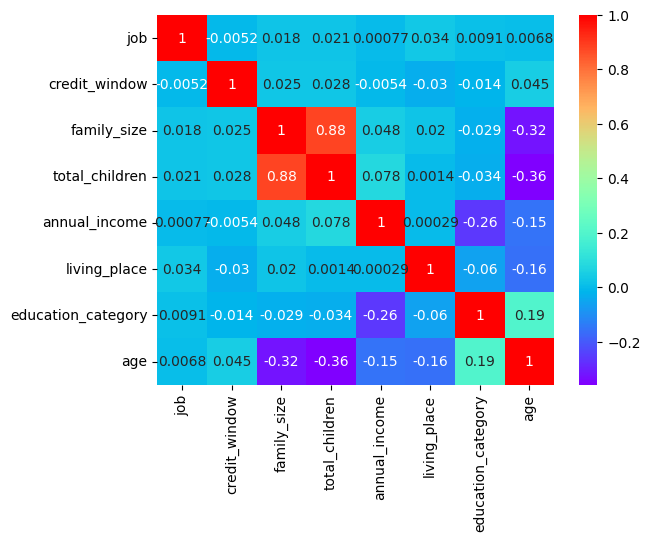

In [169]:
# let's take a look on correlation between these variables
num_features = feature_dataset.select_dtypes(include='number')
sns.heatmap(num_features.corr(), cmap='rainbow', annot = True)


In [170]:
# Feature selection using RandomForestClassifier
# Also need to consider Permutation Importance, Stat Tests

In [171]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel 
        

def train_importance_classifier(X_dataset, Y_dataset):
    """
    Functions trains Random Forest Classifier using X_dataset and Y_dataset 
    Implements Embedded Method Feature Selection using Random Forest 
    
    Args:
        1. X_dataset - pandas.DataFrame object containing independent features 
        2. Y_dataset - pandas.Series object containing dependent target feature
    
    Returns:
        Classifier Model, containing feature importances
    """
    
    classifier = RandomForestClassifier(n_estimators=constants.RANDOM_FOREST_FEATURE_SELECTION_EST)
    classifier.fit(X_dataset, Y_dataset)
    return classifier.feature_importances_

X_dataset = feature_dataset.drop(columns=['bad_client'], inplace=False)
Y_dataset = feature_dataset['bad_client']

feature_importances_ = train_importance_classifier(X_dataset, Y_dataset)
feature_importances_


array([0.26422107, 0.24016664, 0.03733831, 0.02347341, 0.13714824,
       0.02911185, 0.0373553 , 0.01053225, 0.13654441, 0.01927642,
       0.        , 0.        , 0.        , 0.        , 0.02091128,
       0.01542154, 0.01415913, 0.01434014])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'job'),
  Text(1, 0, 'credit_window'),
  Text(2, 0, 'family_size'),
  Text(3, 0, 'total_children'),
  Text(4, 0, 'annual_income'),
  Text(5, 0, 'living_place'),
  Text(6, 0, 'education_category'),
  Text(7, 0, 'employed'),
  Text(8, 0, 'age'),
  Text(9, 0, 'has_car'),
  Text(10, 0, 'has_mobile_phone'),
  Text(11, 0, 'has_phone'),
  Text(12, 0, 'has_email'),
  Text(13, 0, 'has_work_phone'),
  Text(14, 0, 'has_realty'),
  Text(15, 0, 'Female'),
  Text(16, 0, 'Male'),
  Text(17, 0, 'Married')])

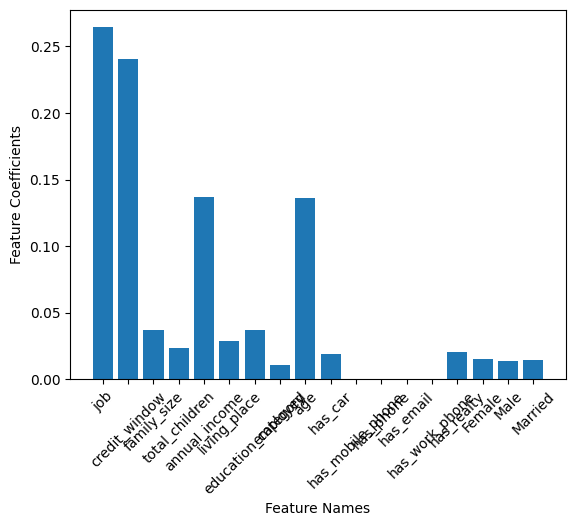

In [172]:
# Visualizing Features coefficients 
features = dict(zip(feature_dataset.columns, feature_importances_))
plt.bar(features.keys(), features.values())
plt.xlabel("Feature Names")
plt.ylabel("Feature Coefficients")
plt.xticks(rotation=45)

In [174]:
# Conclusion: as we can see on the above graph, we have 
# only 3 features, which have some meaningful correlation with the target variable

important_features = feature_dataset[['credit_window', 'job', 'age', 'total_children']]

In [ ]:
# Using L2 Lasso Regularization for feature selection 
from sklearn.linear_model import Lasso 
from sklearn.model_selection import cross_val_score 

alphas = [0.001, 0.01, 0.1, 1, 10, 100]

cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)
X_train, Y_train = feature_dataset.drop(columns=['bad_client'], axis=1), feature_dataset['bad_client']

validation_scores = {} 

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    scores = cross_val_score(
        X=X_train, y=Y_train,
        estimator=Lasso, cv=cross_validation, scoring=""
    ) 
    validation_scores[alpha] = scores.best_score_

print(validation_scores)

plt.bar(validation_scores.keys(), validation_scores.values(), title='Alpha Scores Contrast')
plt.xticks(rotation=45)
plt.xlabel("Alpha Coefficients")
plt.ylabel("Model Performance Scores")


ValueError: '' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [ ]:
# Splitting data into training, testing and validation sets 
from sklearn.model_selection import train_test_split 

def split_data(feature_dataset):
    
    x_set, y_set = feature_dataset[important_features], feature_dataset['bad_client']

    # Splitting into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(
    x_set, y_set, test_size=0.4, stratify=y_set, random_state=1)

    # Splitting into training and validation sets 
    x_train, validation_x_set, y_train, validation_y_set = train_test_split(
    x_train, y_train, test_size=0.4, stratify=y_train, random_state=1)
    return (x_train, y_train), (x_test, y_test), (validation_x_set, validation_y_set)

training_set, test_set, validation_set = split_data(feature_dataset)

test_set[1].value_counts()

bad_client
True     14337
False    14336
Name: count, dtype: int64

In [ ]:
# Selecting models and apply hyperparameter tuning

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score

from sklearn.metrics import make_scorer, log_loss

# we have a huge number of samples (< 100 000), so it's a great idea to use GridSearchCV
# but either RandomizedSearchCV or BayesSearchCV

models: typing.Dict[str, BaseEstimator] = {
    "knn": KNeighborsClassifier, 
    "decision_tree": DecisionTreeClassifier,
    'random_forest': RandomForestClassifier,
}

models_hyper_information = {
    "knn": {
        'n_neighbors': numpy.arange(1, 21, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
    },
    "decision_tree": {
        'max_depth': numpy.array([2, 3, 5, 10, 20]),
        'min_samples_leaf': numpy.array([5, 10, 20, 50, 100]),
        'criterion': ["gini", "entropy"],
    },
    'random_forest': {
        
        'n_estimators': numpy.array([5, 20, 50, 100]),

        'max_features': ['sqrt'],

        'max_depth': numpy.arange(10, 20, 10),

        'min_samples_split': numpy.array([2, 6, 10]),

        'min_samples_leaf': numpy.array([1, 3, 4]),

        'bootstrap': [True, False],
    }
}

optimal_hyper_parameters = {model: {} for model in models.keys()} 
# result hashmap, where we store optimal hyper parameters for the model

# loss function for tuning

loss_function = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

def get_recall_score(x, y, model_name, params):
    """
    Function returns recall score for the model with specified hyperparameters
    Args:
        1. x - independent features 
        2. y - target feature 
        3. model_name - name of the model to select 
        4. params - model hyperparameters 
    Returns:
        recall score of the model 
    """
    try:
        if not model_name in models.keys():
            raise RuntimeError("Invalid Model Name has been passed")
        
        model = models[model_name](**params)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
        model.fit(x_train, y_train)
        bad_client_pred = model.predict(x_test)
        return recall_score(y_test, bad_client_pred)

    except(Exception, RuntimeError):
        Logger.error('failed to predict recall score using model %s' % (model.__class__.__name__))
        raise NotImplemented

def apply_informed_search_cv(
    x_set: pandas.DataFrame, 
    y_set: pandas.Series, 
    model_name: str, 
    hyperparams: typing.Dict,
    error_score,
    folds=10
):
    """
    Function applies HyperParameter Tuning using InformedSearch, based on Bayesian Search
    
    Args:
        1. x_set: pandas.DataFrame object, represents set of independent features,
        2. y_set: pandas.Series object, represents target feature,
        3. model: Machine Learning Model for tuning,
        4. folds: number of splits for cross-validation,
        5. hyperparams: default hyperparams of the model
        6. metric: priority metric for the model
        7. error_score: Scoring Function for error
    """
    
    if not len(x_set) or not len(y_set):
        raise ValueError("X or Y datasets are empty")
        
    new_cvs = GridSearchCV(
        estimator=models[model_name](),
        param_grid=hyperparams,
        scoring=error_score,
        cv=StratifiedKFold(n_splits=folds),
        error_score="raise",
        n_jobs=-1,
    )
    new_cvs.fit(x_set, y_set)
    
    # the lower loss score is, the better model performs 
    
    optimal_hyper_parameters[model_name]["params"] = new_cvs.best_params_
    optimal_hyper_parameters[model_name]["loss_score"] = new_cvs.best_score_
    
    
# Applying Hyperparameter tuning for each model

for model in models.keys():
    try:
        print('training %s...' % (model))
        apply_informed_search_cv(
            x_set=training_set[0],
            y_set=training_set[1],
            model_name=model,
            folds=10,
            hyperparams=models_hyper_information[model],
            error_score=loss_function,
        )
    except(KeyError) as err:
        raise NotImplemented

# Applying Hyperparameter Tuning for each model in the dataset

optimal_models = {
    model_name: models[model_name](**optimal_hyper_parameters[model_name]["params"])
    for model_name in models.keys()
}

optimal_hyper_parameters

training knn...
training decision_tree...
training random_forest...


{'knn': {'params': {'metric': 'manhattan',
   'n_neighbors': 19,
   'weights': 'distance'},
  'loss_score': -0.5673147540437748},
 'decision_tree': {'params': {'criterion': 'gini',
   'max_depth': 20,
   'min_samples_leaf': 100},
  'loss_score': -0.21447776013971373},
 'random_forest': {'params': {'bootstrap': False,
   'max_depth': 10,
   'max_features': 'sqrt',
   'min_samples_leaf': 3,
   'min_samples_split': 2,
   'n_estimators': 20},
  'loss_score': -0.36390584747488003}}

In [ ]:
# let's explore each model on different decision thresholds 

from sklearn.metrics import precision_recall_curve, auc


def evaluate_precision_recall_tradeoff(model, X_data, Y_data):
    """
    Functions evaluates tradeoff between precision and recall, 
    based on model's performance
    
    Args:
        model: Machine Learing Classifier for evaluation 
        X_data: feature set of dependent features
        Y_data: independent feature
        
    Returns:
        precision: precision scores of the model
        recall: - recall scores of the model
        auc_scr: auc scores
        thresholds: decision thresholds used for each individual training
    """
    x_tr, x_t, y_tr, y_t = train_test_split(X_data, Y_data, test_size=0.5, random_state=1)
    
    model.fit(x_tr, y_tr)
    y_pred_proba = model.predict_proba(x_t)[:, 1] # positive class prediction proba
    precision, recall, thresholds = precision_recall_curve(y_t, y_pred_proba)
    auc_scr = auc(recall, precision)
    return precision, recall, auc_scr, thresholds

def get_auc_score(y_test, y_pred):
    return auc(y_test, y_pred)

def visualize_pr_tradeoff(precision, recall, auc_score, thresholds, model_name):
    """
    Visualizes Precision-Recall Tradeoff using plot
    """
    plt.plot(recall, precision, label='Precision-Recall Curve (AUC = %0.2f)' % auc_score)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


In [ ]:
# also, let's add functionality for interpolating threshold using scipy library

from scipy.interpolate import interp1d

def interpolate_threshold(desired_precision: int, actual_precision, actual_recall) -> float:
    """
    Function performs linear interpolation using scipy library 
    for predicting decision threshold value
    
    Args:
        desired_precision: int - percentage of desired precision 
        actual_precision: array of precision values 
        actual_recall: array of recall values
        
    Returns:
        estimated threshold float value
    """
    diff = numpy.abs(numpy.array(actual_precision) - desired_precision)
    closest_index = numpy.argmin(diff)
    
    inter_function = interp1d(actual_precision, actual_recall)
    est_threshold = inter_function(desired_precision)
    return est_threshold


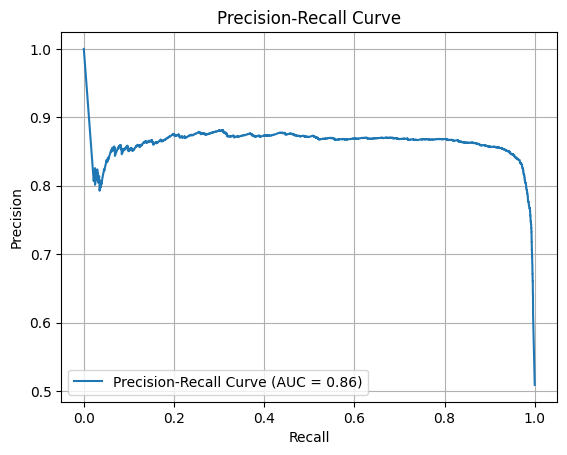

In [ ]:
# evaluating thresholds for KNN 

model = optimal_models["knn"]

precision, recall, auc_score, thresholds = evaluate_precision_recall_tradeoff(
    model, validation_set[0], validation_set[1]
)
        
visualize_pr_tradeoff(precision, recall, auc_score, thresholds, "K Nearest Neighbors")

In [ ]:
# predicting desired precision for our model 
desired_precision = 0.8
knn_threshold = interpolate_threshold(desired_precision, precision, recall)

print(knn_threshold)

0.03654636820465966


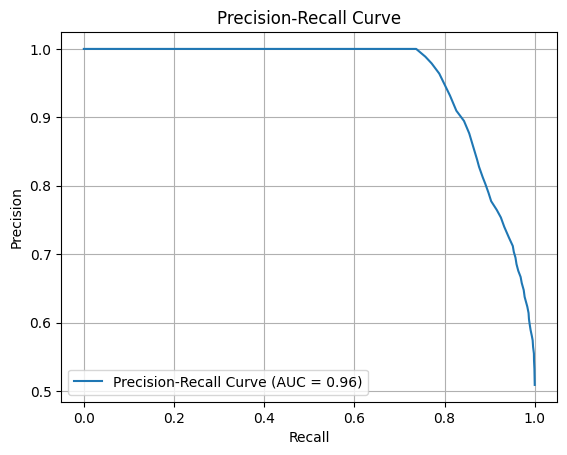

In [ ]:
# let's visualize Decision Tree 
# evaluating thresholds for KNN 


model = optimal_models["decision_tree"]

precision, recall, auc_score, thresholds = evaluate_precision_recall_tradeoff(
    model, validation_set[0], validation_set[1]
)
        
visualize_pr_tradeoff(precision, recall, auc_score, thresholds, "Decision Tree")


In [ ]:
# Let's calculate threshold for Decision Tree 

desired_precision = 0.75
dt_threshold = interpolate_threshold(desired_precision, precision, recall)

print(dt_threshold)

0.926900812721681


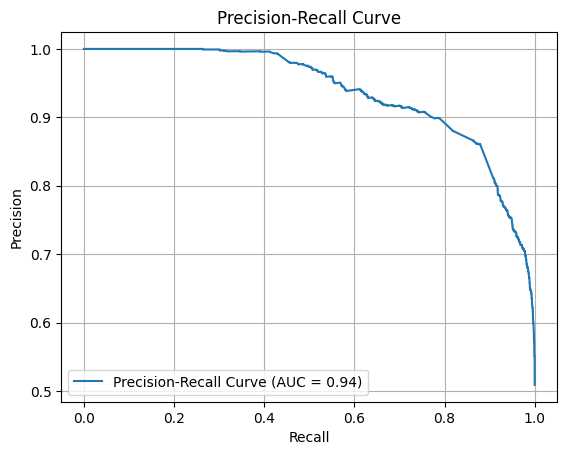

In [ ]:
# evaluating thresholds for Random Forest

model = optimal_models["random_forest"]

precision, recall, auc_score, thresholds = evaluate_precision_recall_tradeoff(
    model, validation_set[0], validation_set[1]
)
        
visualize_pr_tradeoff(precision, recall, auc_score, thresholds, "Random Forest")

In [ ]:
# we are going to use DecisionTree with its threshold

In [ ]:
# let's apply cross-validation and see how it performs on data

print(test_set[1].value_counts())

from sklearn.model_selection import cross_validate 
from sklearn.metrics import (
    precision_score, recall_score,
    accuracy_score, f1_score
)

model = optimal_models["decision_tree"]

cv = StratifiedKFold(n_splits=5)

precision_scores = [] 
recall_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(test_set[0], test_set[1]):

    X_train, X_test = test_set[0].iloc[train_index], test_set[0].iloc[test_index]
    Y_train, Y_test = test_set[1].iloc[train_index], test_set[1].iloc[test_index]
    
    # fitting model 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    probs = numpy.array(model.predict_proba(X_test))[:, 1] # positive class prediction 

    # Applying threshold
    y_transformed = (probs >= dt_threshold).astype(int)

    precision = precision_score(Y_test, y_transformed, average='binary', zero_division=1)
    recall = recall_score(Y_test, y_transformed, average='binary', zero_division=1)
    accuracy = accuracy_score(Y_test, y_transformed)

    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

precision_score = sum(precision_scores) / len(precision_scores)
recall_score = sum(recall_scores) / len(precision_scores)
accuracy_score = sum(accuracy_scores) / len(accuracy_scores)

print('precision-score', precision_score)
print('recall-score', recall_score)
print('accuracy-score', accuracy_score)
print('f1-score', f1_score)

bad_client
True     14337
False    14336
Name: count, dtype: int64
precision-score 1.0
recall-score 0.8174655423447404
accuracy-score 0.908729592583008
f1-score <function f1_score at 0x14fcba9e0>


In [ ]:
# saving machine learning model using pickle 
import pickle 

pickle.dump(model, open("classifier.pkl", mode="wb"))